# Exp_Var_top_iM

In [1]:
from pathlib import Path
import sys
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns

from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *

from pymodulon.util import explained_variance
from pymodulon.imodulondb import imdb_gene_presence
sns.set_style('whitegrid')

## Load the data from ./Data/ folder

In [2]:
precise1k = load_json_model('../Data/p1k.json.gz')

In [3]:
P1K_Gene_Presence_Matrix = pd.read_csv("../Data/P1K_Gene_Presence_Matrix.csv", index_col=0)

In [4]:
RegulonDB_TRN = pd.read_csv('../Data/RegulonDB_TRN_C_and_S.csv', index_col = 0)

In [5]:
biocyc_info = pd.read_csv('../Data/biocyc_info.txt', sep="\t")

### PRECISE-1K: X M A log_tpm gene_presence_matrix

In [6]:
P1K_M = precise1k.M

In [7]:
P1K_A = precise1k.A

In [8]:
P1K_X = precise1k.X

In [9]:
P1K_log_tpm = precise1k.log_tpm

In [10]:
def map_accession_to_gene_name(df, biocyc_info):

    # Reset index if 'Accession' is the index, and rename the column
    if df.index.name == 'Accession' or df.index.name is None:
        df = df.reset_index()
        df.rename(columns={'index': 'Accession'}, inplace=True)
        
    # Merge with biocyc_info to map 'Accession' to 'Gene Name'
    merged_df = df.merge(biocyc_info[['Accession', 'Gene Name']], on='Accession', how='left')

    # Identify rows with NaN 'Gene Name'
    removed_indices = merged_df[merged_df['Gene Name'].isna()]['Accession'].tolist()

    # Print the original indices that were removed
    print("Original indices removed due to NaN 'Gene Name':", removed_indices)

    # Set 'Gene Name' as the new index and drop the 'Accession' column
    merged_df.set_index('Gene Name', inplace=True)
    merged_df.drop(columns=['Accession'], inplace=True)

    # Remove rows with NaN as index
    merged_df = merged_df[merged_df.index.notna()]
    
    return merged_df

In [11]:
P1K_M = map_accession_to_gene_name(P1K_M, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [12]:
P1K_X = map_accession_to_gene_name(P1K_X, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [13]:
P1K_log_tpm = map_accession_to_gene_name(P1K_log_tpm, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [14]:
P1K_Gene_Presence_Matrix = map_accession_to_gene_name(P1K_Gene_Presence_Matrix, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


## Get the top exp var iM for each gene

In [15]:
def calculate_explained_variance(M_matrix, A_matrix, log_tpm):
    # Check if inputs are DataFrames and convert to numpy arrays if needed
    if isinstance(M_matrix, pd.DataFrame) or isinstance(M_matrix, pd.Series):
        M_matrix = M_matrix.values.flatten()
    
    if isinstance(A_matrix, pd.DataFrame):
        A_matrix = A_matrix.values
    
    if isinstance(log_tpm, pd.DataFrame) or isinstance(log_tpm, pd.Series):
        log_tpm = log_tpm.values.flatten()
    
    # Compute the predicted values
    predicted_values = np.dot(M_matrix, A_matrix)  # M_matrix is 1xM, A_matrix is MxN, result is 1xN

    # Calculate the baseline (mean-centered log_tpm)
    baseline = log_tpm - np.mean(log_tpm)  # mean-center the log_tpm

    # Calculate the residual variance
    residuals = log_tpm - predicted_values
    residual_variance = np.sum((residuals - np.mean(residuals)) ** 2)

    # Calculate the total variance
    total_variance = np.sum((log_tpm - np.mean(log_tpm)) ** 2)

    # Compute the explained variance (R^2)
    explained_variance = 1 - (residual_variance / total_variance)
    
    return explained_variance

In [16]:
P1K_M

,Sugar Diacid,Translation,ygdT,OxyR,FlhDC-2,Osmoprotectant,Glutamine,Sialic Acid,yqhI,ROS TALE Amp,...,Tryptophanase,crp KO-2,cyoB/ndh/nuoB KO-2,tpiA KO,Phage Shock,Glyoxylate,CCK-PGI Del,Acetate,Ile/Val,UC-8
Gene Name,,,,,,,,,,,,,,,,,,,,,
thrA,-0.005367,-0.002423,0.010140,-0.001362,-0.017297,0.008631,-0.006491,0.092469,-0.010978,-0.003400,...,-0.012070,-0.008812,0.004996,0.008216,-0.002720,0.007874,-0.004350,-0.013319,0.009296,0.000891
thrB,0.006212,-0.001901,0.007207,0.000073,-0.004829,-0.003186,-0.011677,0.082103,0.011074,-0.004679,...,0.006683,-0.017798,0.000964,0.003273,0.010018,0.002132,-0.005826,-0.010836,-0.066654,-0.003513
thrC,0.010600,-0.002205,0.004961,-0.002289,-0.004938,-0.005587,-0.008127,0.080888,0.007511,0.003887,...,0.008132,-0.018105,-0.007763,0.009103,-0.002566,-0.007120,-0.005676,-0.002164,-0.060155,-0.007025
yaaX,0.011520,0.008573,0.020449,-0.003123,0.002009,-0.026382,-0.016374,0.022484,0.007903,0.017561,...,-0.000139,0.001437,0.001827,-0.008113,0.065835,-0.019238,-0.001622,-0.009303,-0.069669,-0.004241
yaaA,0.003482,-0.002293,-0.010146,0.140794,-0.001754,0.000974,0.023500,-0.017665,0.006247,-0.005761,...,0.017025,0.005473,-0.002252,0.002807,-0.030303,0.000805,0.028367,0.018293,-0.018444,-0.033624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yneP,-0.003644,0.018245,-0.003134,0.004992,-0.000873,-0.021262,-0.012556,0.036707,-0.062935,0.016316,...,0.002969,-0.012892,0.024815,-0.000077,-0.004676,0.015222,0.011431,0.013733,0.011955,0.001203
ynfT,0.010023,-0.030343,-0.000578,-0.002526,-0.000906,0.000805,0.007411,-0.021330,-0.013622,-0.034542,...,0.004057,-0.001059,-0.007595,0.002024,0.001573,-0.029301,-0.007873,0.021424,-0.001528,-0.000353
yoaL,0.001082,0.013560,0.010030,-0.022409,0.006737,-0.012387,-0.002341,-0.010584,-0.015837,0.003776,...,-0.005873,-0.000560,0.008653,0.005759,0.029820,-0.004053,0.026769,0.020823,0.000414,-0.001453


In [17]:
def compute_explained_variance_change(M, A, X, P1K_Gene_Presence_Matrix, gene):
    M = M.loc[[gene]]
    X = X.loc[[gene]]

    # Initialize a dictionary to store the explained variance changes
    exp_var_changes = {}

    # Iterate through each row of A
    for row_name in A.index:
        # Select the corresponding row from A
        modified_A = A.loc[[row_name]]

        # Select the corresponding column from M and X
        modified_M = M[[row_name]]
        modified_X = X

        # Recalculate the explained variance
        new_exp_var = calculate_explained_variance(modified_M, modified_A, modified_X)

        # Store the result in the dictionary
        exp_var_changes[row_name] = new_exp_var

    # Convert the dictionary to a DataFrame
    explained_variance_df = pd.DataFrame.from_dict(exp_var_changes, orient='index', columns=['Explained Variance'])
    explained_variance_df.reset_index(inplace=True)
    
    explained_variance_df.columns = ['iModulon', 'Explained Variance']
    explained_variance_df = explained_variance_df.sort_values(by='Explained Variance', ascending=False)
    
    # Add presence information
    explained_variance_df['Presence'] = explained_variance_df['iModulon'].apply(
        lambda x: 'Yes' if P1K_Gene_Presence_Matrix.loc[gene, x] else 'No'
    )

    # Select the top 3 iModulons with the highest explained variance
    top_3 = explained_variance_df.head(3)

    # Return the top 3 iModulons and their explained variances
    return (
        top_3.iloc[0]['iModulon'], top_3.iloc[0]['Explained Variance'],
        top_3.iloc[1]['iModulon'] if len(top_3) > 1 else None, top_3.iloc[1]['Explained Variance'] if len(top_3) > 1 else None,
        top_3.iloc[2]['iModulon'] if len(top_3) > 2 else None, top_3.iloc[2]['Explained Variance'] if len(top_3) > 2 else None
    )

In [18]:
compute_explained_variance_change(P1K_M, P1K_A, P1K_X, P1K_Gene_Presence_Matrix, 'thrA')

('thrA KO',
 0.6861935869597003,
 'Cysteine-1',
 0.07663828365964043,
 'Thiamine-1',
 0.07562788785712382)

In [19]:
def explained_variance_all_genes(M_matrix, A_matrix, log_tpm, P1K_Gene_Presence_Matrix):
    results = []

    for gene in tqdm(log_tpm.index, desc="Processing genes"):
        try:
            top_1_imodulon, top_1_exp_var, top_2_imodulon, top_2_exp_var, top_3_imodulon, top_3_exp_var = compute_explained_variance_change(
                M_matrix, A_matrix, log_tpm, P1K_Gene_Presence_Matrix, gene
            )
            results.append([gene, top_1_exp_var, top_1_imodulon, top_2_exp_var, top_2_imodulon, top_3_exp_var, top_3_imodulon])
        except Exception as e:
            print(f"Error processing gene {gene}: {e}")
            results.append([gene, None, None, None, None, None, None])

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results, columns=[
        'Gene', 
        'Top_1_Explained_Variance', 'Top_1_iModulon',
        'Top_2_Explained_Variance', 'Top_2_iModulon',
        'Top_3_Explained_Variance', 'Top_3_iModulon'
    ])
    
    return results_df


In [20]:
top_exp_var = explained_variance_all_genes(P1K_M, P1K_A, P1K_X, P1K_Gene_Presence_Matrix)

Processing genes:   0%|          | 0/4257 [00:00<?, ?it/s]

In [75]:
top_exp_var.to_csv('../Data/top_exp_var.csv')

In [76]:
top_exp_var = pd.read_csv('../Data/top_exp_var.csv', index_col=0)

In [23]:
top_exp_var = top_exp_var.set_index('Gene')

In [24]:
top_exp_var

,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon
Gene,,,,,,
thrA,0.686194,thrA KO,0.076638,Cysteine-1,0.075628,Thiamine-1
thrB,0.254512,thrA KO,0.227884,Leu/Val/Ile,0.103394,Leucine
thrC,0.246587,thrA KO,0.234486,Leu/Val/Ile,0.155906,Dipeptide
yaaX,0.171007,Leu/Val/Ile,0.169602,Nucleotide Stress,0.095365,Glycolate
yaaA,0.428612,OxyR,0.171808,Cold Shock,0.129606,UC-8
...,...,...,...,...,...,...
yneP,0.629455,yneP,0.075002,GadXW,0.047460,Resistance
ynfT,0.424437,Cold Shock,0.045140,NRZ,0.033476,LPS
yoaL,0.102746,CpxR,0.066571,Cellulose,0.044315,ppGpp


<AxesSubplot:>

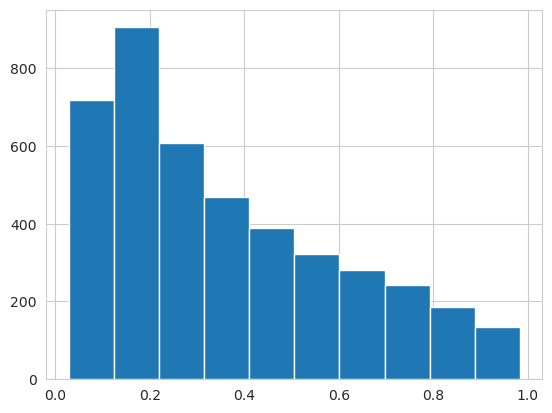

In [25]:
top_exp_var['Top_1_Explained_Variance'].hist()

In [26]:
top_exp_var.nsmallest(10, 'Top_1_Explained_Variance')

,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon
Gene,,,,,,
hofP,0.028429,Translation,0.025940,ykgR,0.022324,ytiC
yfcS,0.031301,ppGpp,0.030958,FlhDC-2,0.030654,IS5
hofO,0.032218,lsrB KO,0.030144,nquinone ALE 3,0.029838,e14 Del
agaC,0.034755,Phosphate-2,0.029729,UC-2,0.025961,malE OE
yaaU,0.036379,Translation,0.025086,FucR/AllR/AraC,0.023241,Leucine
sfmF,0.036993,UC-6,0.035706,Tryptophan,0.034946,Leucine
dicC,0.037217,NO Stress,0.033422,ypjJ,0.033414,cyoB/kdpE/qseB KO
yfdM,0.040620,UC-2,0.024629,Osmoprotectant,0.021516,NDH-1
ymjB,0.041217,Nitrate/Nitrite,0.037120,ldrC,0.029970,GadXW


In [27]:
top_exp_var.nlargest(10, 'Top_1_Explained_Variance')

,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon
Gene,,,,,,
cusB,0.983159,Copper,0.035386,Zinc-1,0.018167,UC-8
thiF,0.979861,Thiamine-1,0.021397,Biotin,0.017967,Propionate
zinT,0.976842,Zinc-1,0.017674,Copper,0.013547,Nickel/Cobalt
cusF,0.975953,Copper,0.032475,Zinc-1,0.012290,Leu/Val/Ile
fliF,0.974904,FlhDC-2,0.066952,FlhDC-1,0.010509,Efflux Pump
thiE,0.973698,Thiamine-1,0.042185,Biotin,0.024334,UC-3
thiC,0.971274,Thiamine-1,0.051218,Biotin,0.028852,NRZ
gatC,0.970559,Crp-2,0.043604,Acetate,0.026965,Dipeptide
flgG,0.969192,FlhDC-2,0.031873,FliA,0.012762,minicoli KOs


In [28]:
def compute_explained_variance_for_a_gene(M, A, X, P1K_Gene_Presence_Matrix, gene):

    M = M.loc[[gene]]
    X = X.loc[[gene]]

    new_exp_var = calculate_explained_variance(M, A, X)

    return new_exp_var

In [29]:
compute_explained_variance_for_a_gene(P1K_M, P1K_A, P1K_X, P1K_Gene_Presence_Matrix, 'yqiD')

0.8963351176871969

In [30]:
def explained_variance_genes(
    M_matrix, A_matrix, log_tpm, P1K_Gene_Presence_Matrix
):
    results = []

    for gene in tqdm(log_tpm.index, desc="Processing genes"):
        try:
            explained_variance = compute_explained_variance_for_a_gene(
                M_matrix, A_matrix, log_tpm, P1K_Gene_Presence_Matrix, gene
            )
            results.append([gene, explained_variance])
        except Exception as e:
            print(f"Error processing gene {gene}: {e}")
            results.append([gene, None, None])

    results_df = pd.DataFrame(results, columns=['Gene', 'Total_Explained_Variance'])
    return results_df

In [31]:
total_exp_var = explained_variance_genes(P1K_M, P1K_A, P1K_X, P1K_Gene_Presence_Matrix)

Processing genes:   0%|          | 0/4257 [00:00<?, ?it/s]

In [32]:
total_exp_var = total_exp_var.set_index('Gene')

In [33]:
total_exp_var

,Total_Explained_Variance
Gene,
thrA,0.899430
thrB,0.808533
thrC,0.824916
yaaX,0.689923
yaaA,0.638300
...,...
yneP,0.748917
ynfT,0.467147
yoaL,0.333663


## Number of Regulators

In [34]:
P1K_RegulonDB= pd.DataFrame(RegulonDB_TRN.sum(axis=1), columns=['num_regulators'])

In [35]:
P1K_Regulon_Number = pd.DataFrame(index=P1K_X.index)
P1K_Regulon_Number['num_regulators'] = 0

# Update the num_regulators values with the values from new_df for the common indices
common_indices = P1K_Regulon_Number.index.intersection(P1K_RegulonDB.index)
P1K_Regulon_Number.loc[common_indices, 'num_regulators'] = P1K_RegulonDB.loc[common_indices, 'num_regulators']

In [56]:
P1K_Regulon_Number['num_regulators'] = P1K_Regulon_Number['num_regulators'].astype('int')

In [57]:
P1K_Regulon_Number['num_regulators']

Gene Name
thrA    3
thrB    1
thrC    1
yaaX    0
yaaA    0
       ..
yneP    0
ynfT    0
yoaL    0
yqhI    0
yqiD    0
Name: num_regulators, Length: 4257, dtype: int64

## iM count

In [58]:
P1K_num_iM= pd.DataFrame( P1K_Gene_Presence_Matrix.sum(axis=1), columns=['num_iM'])

In [59]:
P1K_num_iM

,num_iM
Gene Name,
thrA,3
thrB,2
thrC,1
yaaX,3
yaaA,1
...,...
yneP,1
ynfT,2
yoaL,2


## P1K MAD

In [60]:
def calculate_mad(matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the Median Absolute Deviation (MAD) for each gene in the given matrix and return it as a DataFrame.
    
    Args:
    - matrix (pd.DataFrame): A DataFrame where rows represent genes and columns represent samples.
    
    Returns:
    - pd.DataFrame: A DataFrame with one column named 'mAD', containing the MAD for each gene.
    """
    # Compute the median of each row (gene)
    medians = matrix.median(axis=1)
    
    # Compute the absolute deviation from the median for each element in the matrix
    deviations = matrix.sub(medians, axis=0).abs()
    
    # Compute the median of these deviations for each gene
    mad = deviations.median(axis=1)
    
    # Create a DataFrame with the MAD values
    mad_df = pd.DataFrame({'MAD': mad})
    
    return mad_df

In [61]:
P1K_MAD = calculate_mad(P1K_log_tpm)

In [62]:
P1K_MAD

,MAD
Gene Name,
thrA,0.708056
thrB,0.698585
thrC,0.612527
yaaX,0.737335
yaaA,0.306569
...,...
yneP,1.059936
ynfT,1.776698
yoaL,0.540346


## P1K Median Expression

In [63]:
def calculate_median(matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the Median Absolute Deviation (MAD) for each gene in the given matrix and return it as a DataFrame.
    
    Args:
    - matrix (pd.DataFrame): A DataFrame where rows represent genes and columns represent samples.
    
    Returns:
    - pd.DataFrame: A DataFrame with one column named 'mAD', containing the MAD for each gene.
    """
    # Compute the median of each row (gene)
    medians = matrix.median(axis=1)
    
    # Create a DataFrame with the MAD values
    mad_df = pd.DataFrame({'log_TPM_median': medians})
    
    return mad_df

In [64]:
P1K_median = calculate_median(P1K_log_tpm)

In [65]:
P1K_median

,log_TPM_median
Gene Name,
thrA,9.605329
thrB,9.225274
thrC,9.272277
yaaX,6.283661
yaaA,6.346626
...,...
yneP,1.140369
ynfT,2.466008
yoaL,5.048395


## Range of log tpm

In [66]:
def calculate_range_log_tpm(df):
    # Calculate the range (max - min) for each row (gene)
    df['range_log_tpm'] = df.max(axis=1) - df.min(axis=1)
    
    # Return a new DataFrame with only the 'range_log_tpm' column
    result_df = df[['range_log_tpm']]
    
    return result_df

In [67]:
P1K_range = calculate_range_log_tpm(P1K_log_tpm)

In [68]:
P1K_range

,range_log_tpm
Gene Name,
thrA,11.771901
thrB,7.560994
thrC,7.647762
yaaX,11.817918
yaaA,8.667107
...,...
yneP,4.458041
ynfT,7.650393
yoaL,5.552991


## Quantile Range of log tpm

In [69]:
def calculate_quantile_range(df):
    # Calculate the 95th and 5th quantile for each row (gene)
    q95 = df.quantile(0.95, axis=1)
    q05 = df.quantile(0.05, axis=1)
    
    # Calculate the difference (95th quantile - 5th quantile)
    df['quantile_range_log_tpm'] = q95 - q05
    
    # Return a new DataFrame with only the 'quantile_range' column
    result_df = df[['quantile_range_log_tpm']]
    
    return result_df

In [70]:
P1K_quantile_range = calculate_quantile_range(P1K_log_tpm)

In [71]:
P1K_quantile_range

,quantile_range_log_tpm
Gene Name,
thrA,4.398331
thrB,3.900854
thrC,3.681351
yaaX,4.395201
yaaA,1.920613
...,...
yneP,2.868327
ynfT,6.189466
yoaL,2.841891


## Merge Dataframes

In [72]:
P1K_merged = pd.concat([total_exp_var, top_exp_var, P1K_Regulon_Number, P1K_num_iM, P1K_MAD, P1K_median, P1K_range, P1K_quantile_range], axis=1)

In [73]:
P1K_merged.to_csv('../Data/P1K_merged.csv')

In [74]:
P1K_merged

,Total_Explained_Variance,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon,num_regulators,num_iM,MAD,log_TPM_median,range_log_tpm,quantile_range_log_tpm
thrA,0.899430,0.686194,thrA KO,0.076638,Cysteine-1,0.075628,Thiamine-1,3,3,0.708056,9.605329,11.771901,4.398331
thrB,0.808533,0.254512,thrA KO,0.227884,Leu/Val/Ile,0.103394,Leucine,1,2,0.698585,9.225274,7.560994,3.900854
thrC,0.824916,0.246587,thrA KO,0.234486,Leu/Val/Ile,0.155906,Dipeptide,1,1,0.612527,9.272277,7.647762,3.681351
yaaX,0.689923,0.171007,Leu/Val/Ile,0.169602,Nucleotide Stress,0.095365,Glycolate,0,3,0.737335,6.283661,11.817918,4.395201
yaaA,0.638300,0.428612,OxyR,0.171808,Cold Shock,0.129606,UC-8,0,1,0.306569,6.346626,8.667107,1.920613
...,...,...,...,...,...,...,...,...,...,...,...,...,...
yneP,0.748917,0.629455,yneP,0.075002,GadXW,0.047460,Resistance,0,1,1.059936,1.140369,4.458041,2.868327
ynfT,0.467147,0.424437,Cold Shock,0.045140,NRZ,0.033476,LPS,0,2,1.776698,2.466008,7.650393,6.189466
yoaL,0.333663,0.102746,CpxR,0.066571,Cellulose,0.044315,ppGpp,0,2,0.540346,5.048395,5.552991,2.841891
yqhI,0.894360,0.738529,yqhI,0.091457,UC-8,0.084815,Resistance,0,2,1.195671,1.195671,7.305199,4.985373
